# Модель №1. Наискорейшее обнаружение дефекта. Оценка времени.

0. __Подготовительный этап__ Импорт требуемых библиотек

In [1]:
# Свои библиотеки
from Lib import help_func as HP, LIB, MyPlot as MP

# ОБЩИЕ НАУЧНЫЕ БИБЛИОТЕКИ
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import pydot_ng as pydot
import numpy as np

# НЕЙРОСЕТЕВЫЕ БИБЛИОТЕКИ
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.utils import plot_model

Logger = LIB.Logger  # Логгер

ImportError: No module named 'pydot_ng'

__1. Подготовка данных__ для обучения НС

* Начальные условия и параметры авторегрессии
* Параметры мат.ожидания и дисперсии случайных процессов
* Размер выборки


In [2]:
# Параметры авторегресии 
c0 = 0
a1 = 0  # 0.3
a2 = 0  # 0.5

# Харакетеристики случайного процесса без дефекта
M0 = 0  # Мат. ожидание
D0 = 1  # Дисперсия

# Харакетеристики случайного процесса с дефектом
M_def = 1  # Мат. ожидание
D_def = 1  # Дисперсия

# Параметры подвыборок
M = 10   # размер окна, число входных нейронов НС
T = 50   # NN_M*2 кол-во точек sample в эксперименте
N = T-M  # кол-во подвыборок для родительской выборки

# Диапозон возможного появления дефекта
MIN_PLACE_DEF = 40
MAX_PLACE_DEF = T

# Размеры выборок
K_train = 100000  # размер обучающей выборки
K_test = 100000   # размер контрольной выборки
K = K_test + K_train

# Настройки НС
INPUT_NN = M    # размер вектора входа НС
OUTPUT_NN = 2   # размер вектора выхода НС

LAYERS_1_N = 10
activation_in="relu"

activation_out="softmax"
kernel_initializer="normal"

loss="categorical_crossentropy"
optimizer="SGD"
metrics=["accuracy"]

batch_size=200
epochs=10


__2. Генерация данных__
* Генерация последовательности заданной параметрами выше авторегрессии
* Подготовка обучающей и тестовой выборок__
* Подготовка выборки для постобработки и оценки скорости обнаружения дефекта

In [3]:
# Инициализация генератора случайных чисел, для воспроизводимости результатов
np.random.seed(42)

# Генерация матриц cлучайных последовательностей
R0 = np.random.normal(M0, D0, (T, K_train+K_test))             # Без дефекта. Нормальное распределение Гаусса-Лапласа
R_def = np.random.normal(M_def, D_def, (T, K_train+K_test))  # С дефектом. Нормльное распределение Гаусса-Лапласа
# Для генерации дефектов
# Def_happen = np.random.randint(0, 2, (K_train + K_test))     # Факт дефекта
t_def = np.random.randint(MIN_PLACE_DEF, MAX_PLACE_DEF, (K_train + K_test))      # Место дефекта


findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('C:\\Program Files\\Python36\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000
findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('C:\\Program Files\\Python36\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000


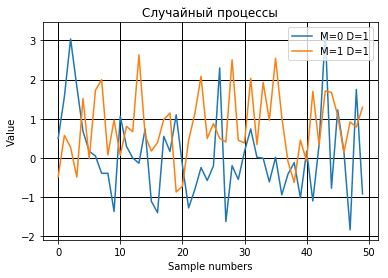

In [4]:
# Простой рисунок
fig = plt.figure();
# Добавление на рисунок прямоугольной (по умолчанию) области рисования
#scatter1 = plt.scatter(0.0, 1.0);

# Графики
graph1 = plt.plot(np.arange(0, T, 1), R0[:, 0], label='M=%s D=%s' % (M0, D0));
graph2 = plt.plot(np.arange(0, T, 1), R_def[:, 0],  label='M=%s D=%s' % (M_def, D_def));

# Сетка
grid1 = plt.grid(True, color='black', linewidth=1.0);

# Название графика
plt.title('Случайный процессы');
plt.legend()

# Подписи осей
plt.ylabel('Value');
plt.xlabel('Sample numbers');

# # Сохранение графика в форматах: pdf, png
# MP.save(name='test', fmt='pdf')
# MP.save(name='test', fmt='png')

# Показ графика
plt.show()


__Формула авторегресии N порядка__:

$ x_{t} = c + \sum_{i=1}^{N} (a_{i}*x_{t-i}) + \epsilon_{t} $

In [5]:

# Уравнение авторегрессия второго порядка
# Xn = c + a1 * Xn-1 + a2*Xn-2 + En  (En - шум случ. сост. с зада M и D)

temp = np.zeros((T, K))  # процессы с дефекто в момент t
X = np.zeros((M, K * (T - M)))  # мини подвыборки по NN_MM элементов
Y = np.zeros(K * (T - M)).astype('int')          # учитель, есть дефект, нет дефекта

status_bar = LIB.ProcessingCounter("[GENERATE SAMPLES] it is processing...",
                                           max_cnt_value=K * N,
                                           every_cnt_percent=10,
                                           silence=False)

for j in range(0, K):  # для каждого эксперимента делаем выборку
    for i in range(0, t_def[j]):
        temp[i][j] = c0 + R0[i][j]   # + a1 * temp[i-1][j] + a2 * temp[i-2][j]
        if i > 0:
            temp[i][j] += a1 * temp[i-1][j]
        if i > 1:
            temp[i][j] += a2 * temp[i-2][j]
    for i in range(t_def[j], T):
        temp[i][j] = c0 + R_def[i][j]  # + a1 * X[i-1][j] + a2 * X[i-2][j]

    for k in range(0, T - M):
        status_bar.increment_counter()  # инкремент счетчик статус бара
        v = (T - M) * j + k
        X[:, v] = temp[k:M+k, j]
        Y[v] = 1 if M+k >= t_def[j] else 0

Logger.info("Window with defect: %s" % Y.sum(axis=0))
Logger.info("Window without defect: %s" % (Y.size - Y.sum(axis=0)))
Logger.info("Total cnt window: %s" % Y.size)


[GENERATE SAMPLES] it is processing.... Percent:10%. (Counter = 800000)
[GENERATE SAMPLES] it is processing.... Percent:20%. (Counter = 1600000)
[GENERATE SAMPLES] it is processing.... Percent:30%. (Counter = 2400000)
[GENERATE SAMPLES] it is processing.... Percent:40%. (Counter = 3200000)
[GENERATE SAMPLES] it is processing.... Percent:50%. (Counter = 4000000)
[GENERATE SAMPLES] it is processing.... Percent:60%. (Counter = 4800000)
[GENERATE SAMPLES] it is processing.... Percent:70%. (Counter = 5600000)
[GENERATE SAMPLES] it is processing.... Percent:80%. (Counter = 6400000)
[GENERATE SAMPLES] it is processing.... Percent:90%. (Counter = 7200000)
[GENERATE SAMPLES] it is processing.... Percent:100%. (Counter = 8000000)
Window with defect: 1099938
Window without defect: 6900062
Total cnt window: 8000000


In [6]:

# Транспонирование
X_train = X[:,:K_train*(T - M)].transpose()
X_test = X[:, K_train*(T - M):].transpose()

y_train=Y[:K_train*(T - M)]
y_test=Y[K_train*(T - M):]

# Указание типа данных
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = y_train.astype(int)
Y_test = y_test.astype(int)

# Преобразуем метки в категории
Y_train = np_utils.to_categorical(Y_train, 2)
Y_test = np_utils.to_categorical(Y_test, 2)

# 0 - > [1, 0]
# 1 - > [0, 1]

# Создаем последовательную модель
model = Sequential()

# Добавляем уровни сети
model.add(Dense(LAYERS_1_N, input_dim=INPUT_NN, activation=activation_in, kernel_initializer=kernel_initializer))
model.add(Dense(OUTPUT_NN, activation=activation_out, kernel_initializer=kernel_initializer))

# Компилируем модель
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

print(model.summary())

# Обучаем сеть
model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=2)

#plot_model(model, to_file='model.png', show_shapes=True)

# Оцениваем качество обучения сети на тестовых данных
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Точность работы на тестовых данных: %.2f%%" % (scores[1]*100))

# Запускаем сеть на входных данных
predictions = model.predict(X_test)

# Преобразуем входные данные сети из категорий в метки классов (цифры от 0 - 9)
predictions = np.argmax(predictions, axis=1)

# Пост обработка: "Оценка скорости обнаружения дефекта (на каком такте) на РОДИТЕЛЬСКОЙ выборке"

Logger.info("Postprocessing START!")

y_place = t_def[K_train:]  # тестовые данные 

Err = []  # вспомогательный массив для дефектов
Err1 = 0  # дефект не найден, а он есть
Err2 = 0  # дефект найден, но его нет

V = (-100)*np.ones((y_place.size, N)).astype("int")  # скорость предсказания (-100 не было, +100 пропуск, >0 задержка тактов)
K_rigth_found_def = np.zeros(y_place.size).astype("int")

for k in range(y_place.size):
    for n in range(N):
        i = k*N + n
        Err.append(predictions[i] - y_test[i])
        
        if predictions[i] > 0:  # сеть нашла дефект
            V[k][n] = (M + n - y_place[k])
            if V[k][n] >= 0:
                K_rigth_found_def[k] = 1
            #break  # останавливаем поиск
        else:
            if y_test[i] > 0:
                V[k][n] = 100

Err1 = sum([1 if v > 0 else 0 for v in Err]) / predictions.size  # ошибка 1 рода
Err2 = sum([1 if v < 0 else 0 for v in Err]) / predictions.size  # ошибка 2 рода

V_sred = 0
temp_k = 0
for k in range(y_place.size):
    for n in range(0, N):
        if V[k][n] >= 0 and V[k][n] != 100:
            V_sred += V[k, n]
            temp_k +=1
            break
V_sred = V_sred / temp_k


Logger.info("Err1: %.2f%%\nErr2: %.2f%%\n" % (Err1*100, Err2*100))
Logger.info("V_rigth_cnt_find [Кол-во верных обнаружений]: %s/%s\n"
            "V_min_sred_rigth [Мин кол-во тактов до правильного обнаружения]: %.2f\n"
            % (K_rigth_found_def.sum(axis=0), y_place.size, V_sred))
print(V)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total params: 132
Trainable params: 132
Non-trainable params: 0
_________________________________________________________________
None
Train on 3200000 samples, validate on 800000 samples
Epoch 1/10
 - 21s - loss: 0.3290 - acc: 0.8808 - val_loss: 0.3185 - val_acc: 0.8836
Epoch 2/10
 - 21s - loss: 0.3164 - acc: 0.8846 - val_loss: 0.3170 - val_acc: 0.8842
Epoch 3/10
 - 21s - loss: 0.3156 - acc: 0.8850 - val_loss: 0.3166 - val_acc: 0.8844
Epoch 4/10
 - 21s - loss: 0.3153 - acc: 0.8852 - val_loss: 0.3165 - val_acc: 0.8845
Epoch 5/10
 - 21s - loss: 0.3152 - acc: 0.8852 - val_loss: 0.3164 - val_acc: 0.8846
Epoch 6/10
 - 21s - loss: 0.3151 - acc: 0.8853 - val_loss: 0.3